In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [7]:
def convTransposeBlock(in_channels , out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels , out_channels , 4 , 2 , 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )
def convBlock(in_channels , out_channels , k , s , p):
    return nn.Sequential(
        nn.Conv2d(in_channels , out_channels , k , s , p),
    )
def disConvBlock(in_channels , out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels , 4 , 2 , 1),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )


In [8]:
class Generator(nn.Module):
    def __init__(self , noise_size=100 , channels=128 , out_channels = 3):
        super(Generator , self).__init__()
        self.initial = nn.Sequential (
            nn.Linear(  noise_size , (channels*8) *4*4 ),
            nn.Dropout(0.1),
            nn.ReLU()
        )
        self.generator1 = nn.Sequential(
            convTransposeBlock(channels*8 , channels*4),       # (1024,4,4)  ----->  (512,8,8)
            convTransposeBlock(channels*4 , channels*2),       # (512,8,8)  ------>  (256,16,16)
            convTransposeBlock(channels*2 , channels*2),       # (256,16,16)  ---->  (256,32,32)
            convTransposeBlock(channels*2 , channels*1),       # (256,32,32)  ---->  (128,64,64)
            convTransposeBlock(channels*1 , channels*1),       # (128,64,64)  ---->  (128,128,128)
        )
        self.levelUp = nn.Sequential(
            convTransposeBlock(channels*1 , channels*1),       # (128,128,128)  -->  (128,256,256)
        )
        self.toRGB = nn.Sequential(
            convBlock(channels*1 , out_channels , 1 , 1 , 0)   # dimensions remain same
        )
        self.tanh = nn.Tanh()
    def forward(self , noise , epoch , alpha):
         x = self.initial(noise)
         x = x.view(-1 , 128*8 , 4 , 4 )

         if epoch+1 >= level_up_threshold:
               images_128dim_128c = self.generator1(x)
               images_256dim_128c = self.levelUp(images_128dim_128c)
               images = alpha*(self.toRGB(images_256dim_128c)) + (1-alpha)*(self.toRGB(F.interpolate(images_128dim_128c,scale_factor=2, mode='nearest')))
         else:
              images_128dim_128c = self.generator1(x)
              images = self.toRGB(images_128dim_128c)

         return self.tanh(images)


In [9]:
class Discriminator(nn.Module):
    def __init__(self , input_channels = 3 , channels=8 , num_classes=2):
        super(Discriminator , self).__init__()

        self.fromRGB =  nn.Sequential(
          convBlock(input_channels , channels , 1 , 1 , 0),   #dimensions remains same
          nn.LeakyReLU(0.2)
        )
        self.avgPool = nn.AvgPool2d(2,2)
        self.levelUp = nn.Sequential(
          disConvBlock(channels*1,channels*1),        # (8,256,256)  ----->  (8,128,128)
        )
        self.discriminator = nn.Sequential(
          disConvBlock(channels*1,channels*2),        # (8,128,128)  ----->  (16,64,64)
          disConvBlock(channels*2,channels*4),        # (16,64,64)  ---->  (32,32,32)
          disConvBlock(channels*4,channels*8),        # (32,32,32)  ------>  (64,16,16)
        )
        self.fc1 = nn.Linear(64*16*16 , 512)
        self.batchNorm = nn.BatchNorm1d(512)
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.fc2 = nn.Linear(512 , 1)
        self.classifyingLayer = nn.Linear(512 , num_classes)
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()

    def forward(self , images , epoch , alpha , classification=False):

        if epoch+1 >=level_up_threshold:
             images_128dim_8c = self.levelUp(self.fromRGB(images))
             images_128dim_8c = alpha*(images_128dim_8c) + (1-alpha)*(self.avgPool(self.fromRGB(images)))
        else:
             images_128dim_8c = self.fromRGB(images)

        images = self.discriminator(images_128dim_8c)
        images = images.view(images.size(0) , -1)
        images_flattened = self.fc1(images)
        probability = self.fc2(self.leakyrelu(self.batchNorm(images_flattened)))

        if classification:
              class_probabilities = self.classifyingLayer(self.dropout(self.relu(images_flattened)))
              return probability.squeeze() , class_probabilities

        else: return probability.squeeze()

In [165]:
generator = Generator()   
discriminator = Discriminator()   

checkpoint_path = "/Users/abhinavpatel/Downloads/35th_epoch.pth"
checkpoint = torch.load(checkpoint_path , map_location=torch.device('cpu') , weights_only=True)

 
generator.load_state_dict(checkpoint['gen_state_dict'])
discriminator.load_state_dict(checkpoint['disc_state_dict'])

 
epoch = checkpoint['epoch']
alpha = checkpoint['alpha']
level_up_threshold = 13       ###in the training script , the level_up_threshold is 13

print(f"Checkpoint loaded from epoch {epoch} and alpha is {alpha}")
 
def generate_and_classify():
    generator.eval()
    discriminator.eval()
    noise = torch.randn(1 ,100) 
    image_generated = (generator(noise,epoch,alpha)) 
    image = image_generated.squeeze(0).permute(1, 2, 0)  * 0.5 + 0.5
    plt.imshow(image.detach().cpu().numpy())
    plt.title("Generated Image")
    plt.show()
    ( _ , class_prob) = discriminator(image_generated,epoch,alpha,True)
    _ , prediction = torch.max(class_prob , 1)
    classs = prediction.item()
    gender = "Female" if classs==0 else "Male"
    print(f"    The discriminator classifies this image as a {gender}.")

Checkpoint loaded from epoch 35 and alpha is 0.8666666666666666


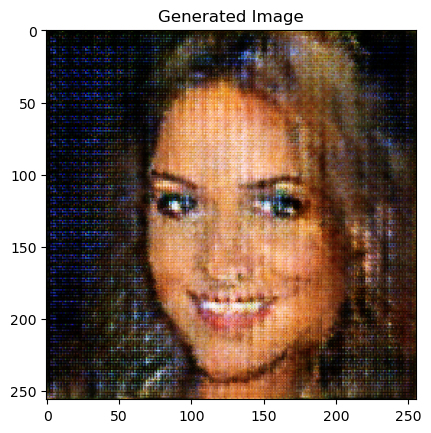

    The discriminator classifies this image as a Female.


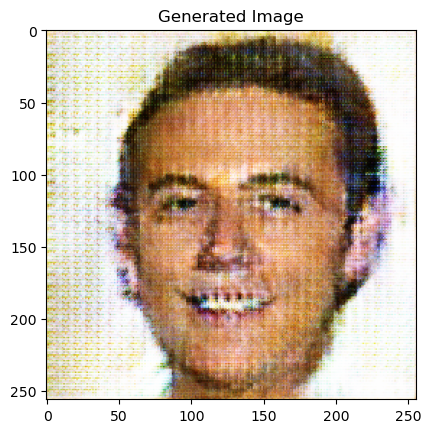

    The discriminator classifies this image as a Male.


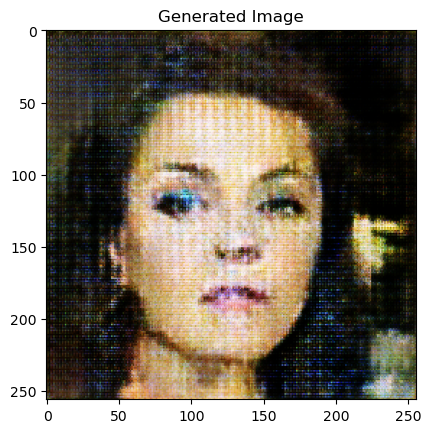

    The discriminator classifies this image as a Female.


In [186]:
for _ in range(3):
    generate_and_classify()